Import Library

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage import io, morphology, measure, segmentation, filters
from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import active_contour 
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops


Show Original Image

In [2]:
# Load image
# Baca citra dalam format BGR (default OpenCV)
image = cv2.imread('./image/image1.jpg')

# Tampilkan citra Original (RGB)
cv2.imshow('Image Original', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# plt.imshow(image)
# plt.colorbar()

Convert to HSV

In [3]:
#load original citra
image_bgr = cv2.imread('./image/image1.jpg')

# Konversi citra ke format HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Simpan citra HSV
cv2.imwrite('./image/hsv/image1_hsv.jpg', image_hsv)

# Tampilkan citra HSV
cv2.imshow('HSV Image', image_hsv)
cv2.waitKey(0)
cv2.destroyAllWindows()

Using Threshold in HSV

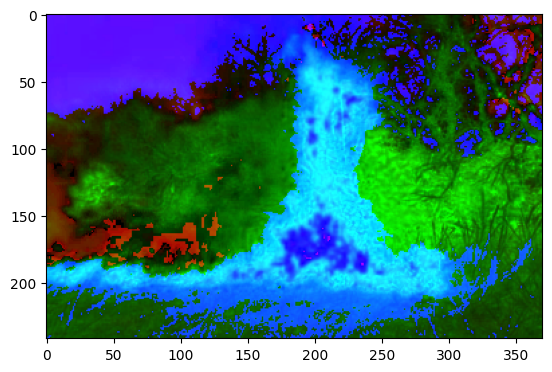

In [105]:
# Ambil channel H, S, V dari citra HSV
h_channel, s_channel, v_channel = cv2.split(image_hsv)

# Threshold pada channel V menggunakan nilai threshold min dan max
# threshold_min = 130
# threshold_min = 143 (yang ini)
threshold_min_v = 123
threshold_max_v = 255

_v, v_thresh = cv2.threshold(v_channel, threshold_min_v, threshold_max_v, cv2.THRESH_BINARY)

threshold_min_s = 123
threshold_max_s = 255
_s, s_thresh = cv2.threshold(s_channel, threshold_min_s, threshold_max_s, cv2.THRESH_BINARY)

# threshold_min_h = 255
# threshold_max_h = 255
# _h, h_thresh = cv2.threshold(s_channel, threshold_min_h, threshold_max_h, cv2.THRESH_BINARY)

# Gabungkan kembali channel H, S, dan channel V yang telah di-threshold
thresholded_image = cv2.merge((h_channel, s_thresh, v_thresh))

# Simpan citra HSV Threshold
cv2.imwrite('./image/hsv/image1_hsv_threshold.jpg', thresholded_image)

# Tampilkan citra hasil thresholding
cv2.imshow('Thresholded Image', thresholded_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(thresholded_image)
plt.show()

Convert Citra to Grayscale

In [106]:
def hsv_to_grayscale(hsv_image):
    # Ambil komponen Hue, Saturation, dan Value dari citra HSV
    hue, saturation, value = cv2.split(hsv_image)
    
    # Hitung nilai rata-rata dari komponen Hue, Saturation, dan Value
    grayscale_image = np.mean([hue, saturation, value], axis=0).astype(np.uint8)
    
    return grayscale_image

# Baca citra HSV
hsv_image = cv2.imread('./image/hsv/image1_hsv_threshold.jpg', cv2.IMREAD_COLOR)

# Konversi citra dari format HSV ke grayscale
grayscale_image = hsv_to_grayscale(hsv_image)

# Simpan citra grayscale
cv2.imwrite('./image/grayscale/image1_grayscale.jpg', grayscale_image)

# Tampilkan citra grayscale
cv2.imshow('Grayscale Image', grayscale_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Using Threshold in Grayscale

In [114]:
def apply_threshold(image, threshold_value):
    # Lakukan thresholding menggunakan metode Binary
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    return thresholded_image

# Baca citra grayscale
grayscale_image = cv2.imread('./image/grayscale/image1_grayscale.jpg', cv2.IMREAD_GRAYSCALE)

# Tentukan nilai threshold
# threshold_value = 143
threshold_value = 163

# Terapkan thresholding pada citra grayscale
thresholded_image = apply_threshold(grayscale_image, threshold_value)
# combined = thresholded_image

# menghilangkan noise yang ada pada citra walaupun sudah dilakukan threshold
filtered_image = cv2.medianBlur(thresholded_image, 3)
combined = filtered_image

# Simpan citra hasil thresholding
cv2.imwrite('./image/grayscale/image1_grayscale_thresholding.jpg', filtered_image)

# Tampilkan citra hasil thresholding
cv2.imshow('Thresholded Image', filtered_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Threshold limit: 163.0


Performing Otsu's Binarization

Threshold limit: 0.0


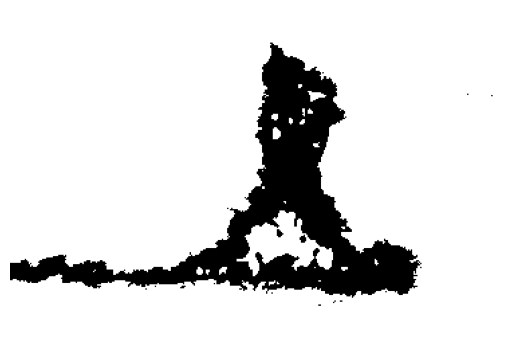

In [117]:
ret, thresh = cv2.threshold(combined, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print("Threshold limit: " + str(ret))

plt.axis('off')
plt.imshow(thresh, cmap='gray')

Specifying the Background and Foreground after Noise Removal

In [110]:
# noise removal
# kernel = np.ones((3, 3), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel, iterations=2)

# # sure background area
# sure_bg = cv2.dilate(opening, kernel, iterations = 3)

# sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
ret, sure_fg = cv2.threshold(dist_transform, 0.01*dist_transform.max(),255,0)

sure_bg = cv2.subtract(opening, sure_fg.astype(np.uint8))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

Performing Distance Transform

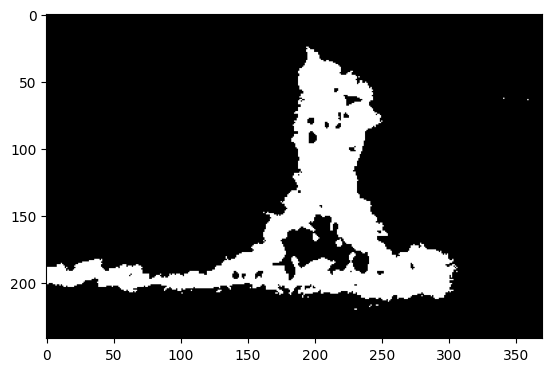

In [111]:
plt.imshow(sure_fg, cmap='gray')

Plotting the Foreground, Background and the Subtracted Image

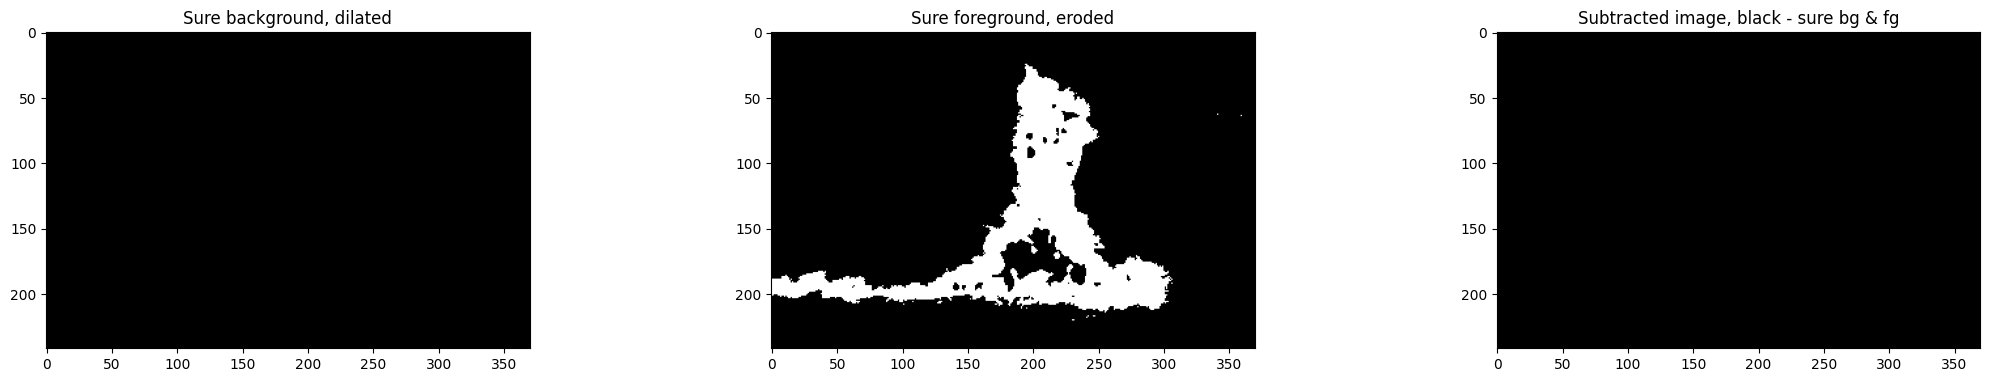

In [112]:
fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(131)
plt.imshow(sure_bg, cmap = 'gray')
plt.title('Sure background, dilated')

plt.subplot(132)
plt.imshow(sure_fg, cmap = 'gray')
plt.title('Sure foreground, eroded')

plt.subplot(133)
plt.imshow(unknown, cmap = 'gray')
plt.title('Subtracted image, black - sure bg & fg')
plt.tight_layout()

plt.subplots_adjust(wspace = 0.5)
# fine tuning 

Displaying the connected components sure_bg and sure_fg

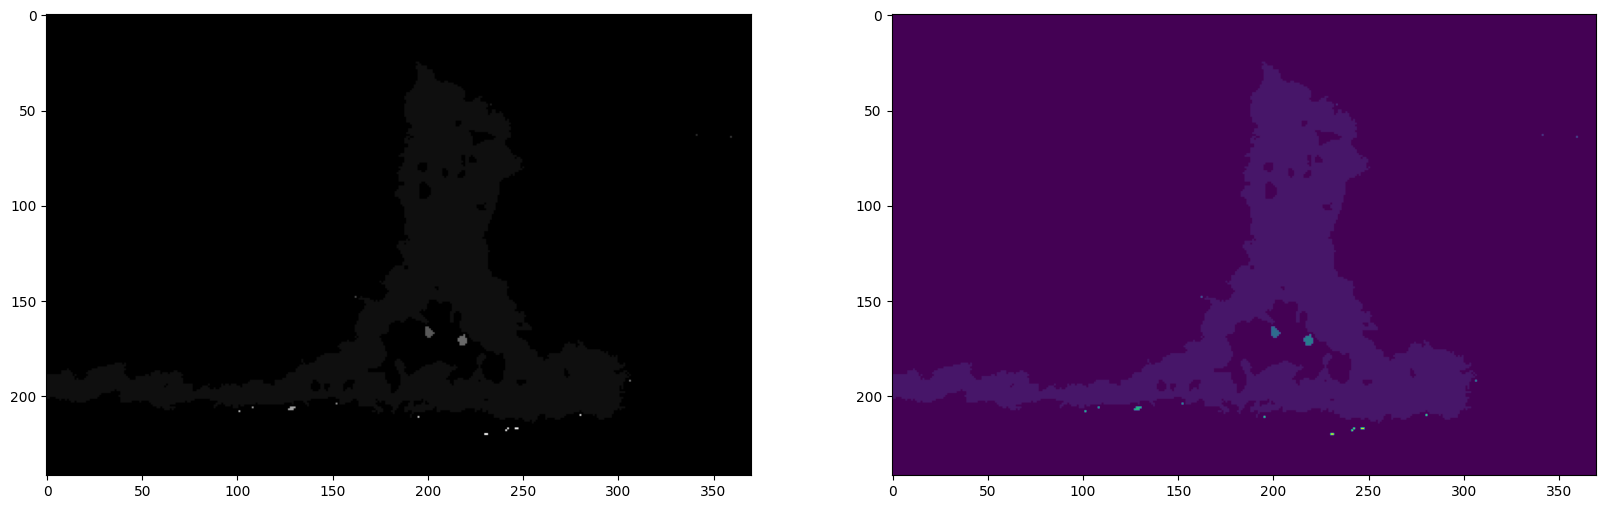

In [113]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0

fig = plt.figure(figsize = (20, 10)) # to change figsize
plt.subplot(121)
plt.imshow(markers, cmap = 'gray')
plt.subplot(122)
plt.imshow(markers)

Applying Watershed Segmentation

In [103]:
markers = cv2.watershed(image, markers)
image[markers == -1] = [0, 255,0]

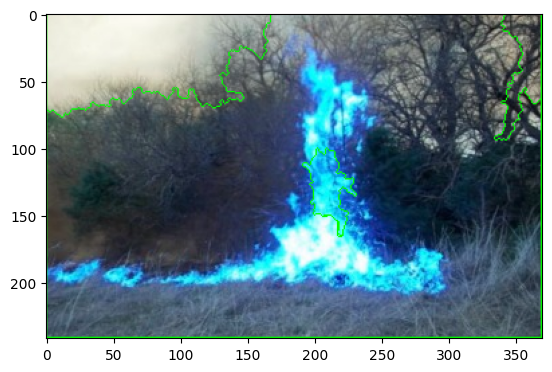

In [104]:
plt.imshow(image)

Contour image

In [7]:
# # Load citra sebaran api
image_contour = cv2.imread('./image/grayscale/image1_grayscale_thresholding.jpg')

# Konversi citra ke citra biner (grayscale dengan tipe data CV_8UC1)
gray = cv2.cvtColor(image_contour, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

# Temukan kontur pada citra biner
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Gambar kontur pada citra asli
cv2.drawContours(image_contour, contours, -1, (0, 255, 0), 2)

# # Draw contours on the mask image
# cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

# Tampilkan citra dengan kontur
cv2.imshow('Fire Contour', image_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
# Load citra sebaran api
image_test_contour = cv2.imread('./image/image1.jpg')

## convert to hsv
hsv = cv2.cvtColor(image_test_contour, cv2.COLOR_BGR2HSV)

# # Tentukan rentang warna sebaran api dalam format HSV
lower_fire = np.array([23, 100, 100])
upper_fire = np.array([30, 255, 255])

# Buat mask menggunakan inRange
mask = cv2.inRange(hsv, lower_fire, upper_fire)

# Temukan kontur pada citra hasil operasi morfologi
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Gambar kontur pada citra asli
cv2.drawContours(image_test_contour, contours, -1, (0, 255, 0), 1)

# Tampilkan citra dengan kontur
cv2.imshow('Fire Contour', image_test_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()


Morphologi terbuka

In [9]:
# Define the structuring element for morphological operation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

# Perform morphological opening
# opened = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
opened = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)

# Tampilkan citra hasil operasi morfologi terbuka
cv2.imwrite('image_morphology.png', opened)
cv2.imshow('Opened Image', opened)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# # Perform distance transform
# distance_transform = distance_transform_edt(binary)

# # Normalize the distance transform
# normalized_distance = distance_transform / distance_transform.max()

# plt.imshow(normalized_distance)
# plt.title('Opened Image')
# plt.show()

In [11]:
# sure_bg = cv2.dilate(opened, kernel, iterations=5)
# plt.imshow(sure_bg, 'gray')

# # yang hitam sudah pasti background

In [12]:
# # sudah pasti objeknya (fore ground) yang berwarna putih menggunakan operasi erosi
# sure_fg = cv2.erode(opened, kernel, iterations=9)
# plt.imshow(sure_fg, 'gray')

# dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
# plt.imshow(dist_transform, 'gray')

# ret, sure_fg = cv2.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
# plt.imshow(sure_fg, 'gray')

# sure_fg = np.uint8(sure_fg)

In [13]:
# # mengetahui area yang bukan foreground dan bukan background
# unknown = cv2.subtract(sure_bg, sure_fg)
# plt.imshow(unknown, 'gray')

In [14]:
# # buat marker
# ret3, markers = cv2.connectedComponents(sure_fg)
# plt.imshow(markers, 'gray')

In [15]:
# # ditandai yang background berwarna hitam
# markers = markers + 10
# markers[unknown == 255] = 0
# plt.imshow(markers, 'gray')

In [16]:
# # lakukan watershed
# markers = cv2.watershed(image, markers)
# plt.imshow(markers)

Transformasi Jarak

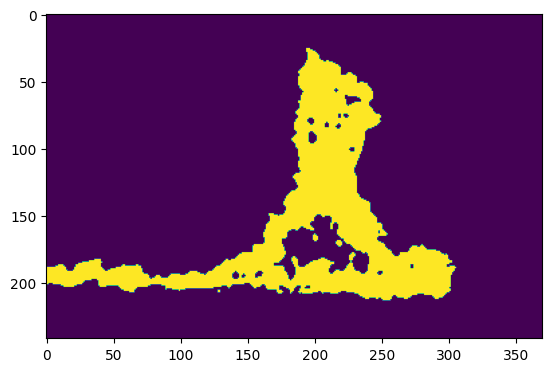

In [17]:
# Dapatkan transformasi jarak dari citra hasil morfologi terbuka
dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 3)

# Normalisasi transformasi jarak untuk tampilan yang lebih baik
dist_transform = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

ret, sure_fg = cv2.threshold(dist_transform, 0.01*dist_transform.max(), 255,0 )
plt.imshow(sure_fg)

# Tampilkan citra transformasi jarak
cv2.imwrite('image_transformasi_jarak.png', dist_transform)
cv2.imshow('Distance Transform', dist_transform)
cv2.waitKey(0)
cv2.destroyAllWindows()

sure_fg = np.uint8(sure_fg)

# # Dapatkan area yang tidak termasuk dalam area objek menggunakan operasi pengurangan (dapatkan area background)
sure_bg = cv2.subtract(opened, sure_fg.astype(np.uint8))

# plt.imshow(sure_bg)

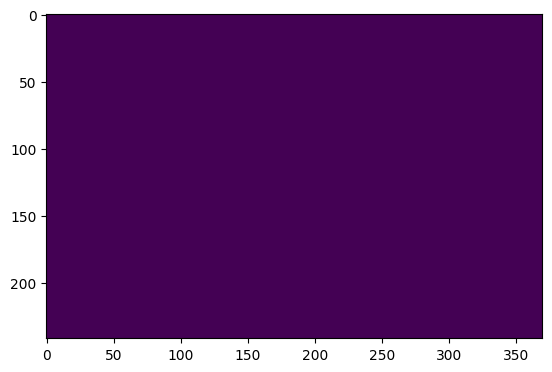

In [18]:
# mengambil daerah yang bukan background dan bukan foreground dari citra

unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown)

Gabungan gambar Transformasi jarak

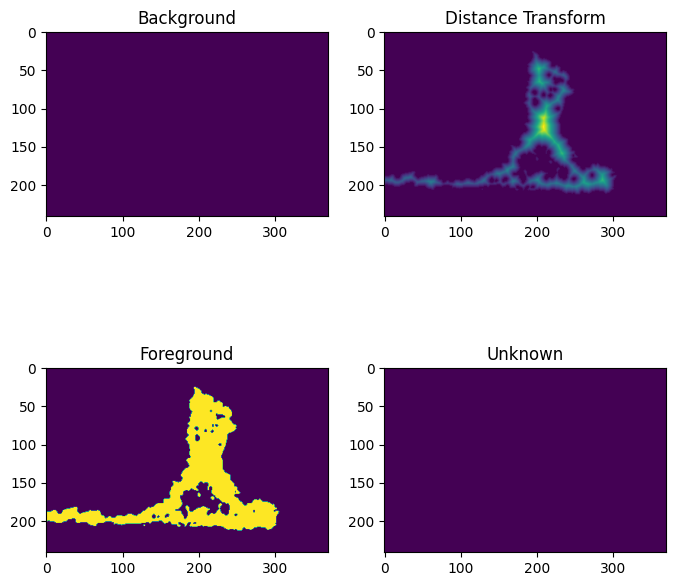

In [19]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
# sure_bg = cv2.dilate(combined, kernel, iterations=3)
# imshow(sure_bg, axes[0,0])
axes[0, 0].imshow(sure_bg)
axes[0, 0].set_title('Background')

# Distance transform
# dist = cv2.distanceTransform(combined, cv2.DIST_L2, 5)
# imshow(dist, axes[0,1])
axes[0, 1].imshow(dist_transform)
axes[0, 1].set_title('Distance Transform')

#foreground area
# ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
# sure_fg = sure_fg.astype(np.uint8)
# imshow(sure_fg, axes[1,0])
axes[1, 0].imshow(sure_fg)
axes[1, 0].set_title('Foreground')

# unknown area
# unknown = cv2.subtract(sure_bg, sure_fg)
# imshow(unknown, axes[1,1])
axes[1, 1].imshow(unknown)
axes[1, 1].set_title('Unknown')

plt.show()

Marker 

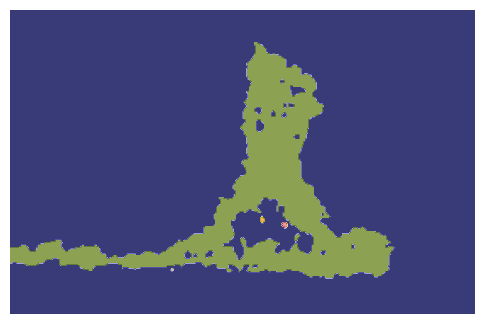

In [28]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)
  
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0
  
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

Text(0.5, 1.0, 'Segmented Image')

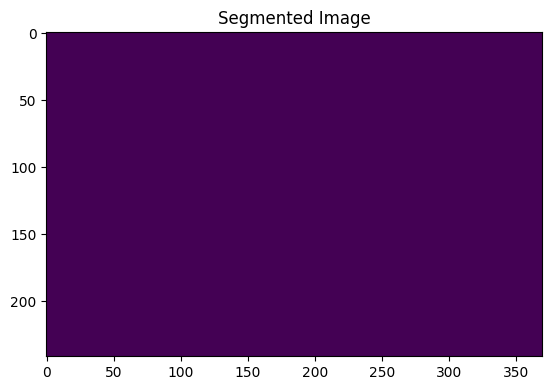

In [29]:
markers, num_markers = measure.label(sure_bg, return_num=True)

# Perform watershed segmentation
labels = segmentation.watershed(dist_transform, markers)

plt.imshow(labels)
plt.title('Segmented Image')

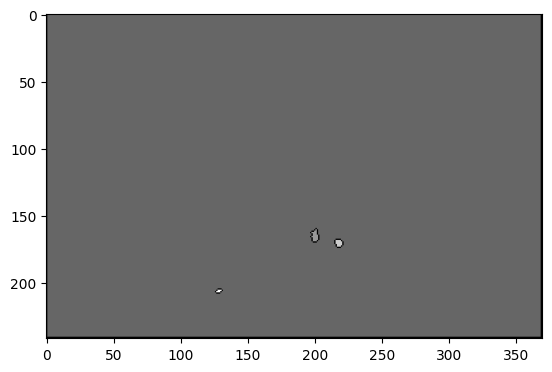

In [30]:
markess = markerss + 10
markerss[unknown == 255] = 0
plt.imshow(markerss, 'gray')

In [31]:
img = cv2.imread('./image/image1.jpg')
markerss = cv2.watershed(img, markerss)

In [32]:
print(markerss)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


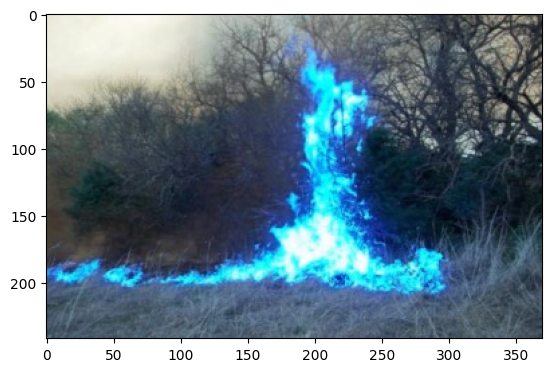

In [33]:
img[markers == -1] = [255,0,0]
plt.imshow(img)

Segmentasi Watershed

In [27]:
# # Terapkan segmentasi Watershed
# ret, markers = cv2.connectedComponents(dist_transform)

# # Tandai kontur pada citra asli dengan warna biru
# image_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# # image_rgb[markers == -1] = [0, 0, 255]

# # # Tampilkan citra hasil segmentasi Watershed
# # cv2.imshow('Segmented Image', image_rgb)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()